In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images/280706862_14c30d734a.jpg
/kaggle/input/flickr8k/Images/2100735137_05c6079537.jpg
/kaggle/input/f

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
# Importing required libraries
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# load Xception model
model = Xception()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

91884032/91884032 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Xception
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# saving the extracted features
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [5]:
# load features from pickle
with open('/kaggle/input/saved-models/features.pkl', 'rb') as f:
    features = pickle.load(f)

In [6]:
# loading all the captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [10]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
# preprocess the text
clean(mapping)

In [12]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [16]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
# saving the tokenizer
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))

In [17]:
vocab_size

8485

In [18]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
# Splitting data into training and testing
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

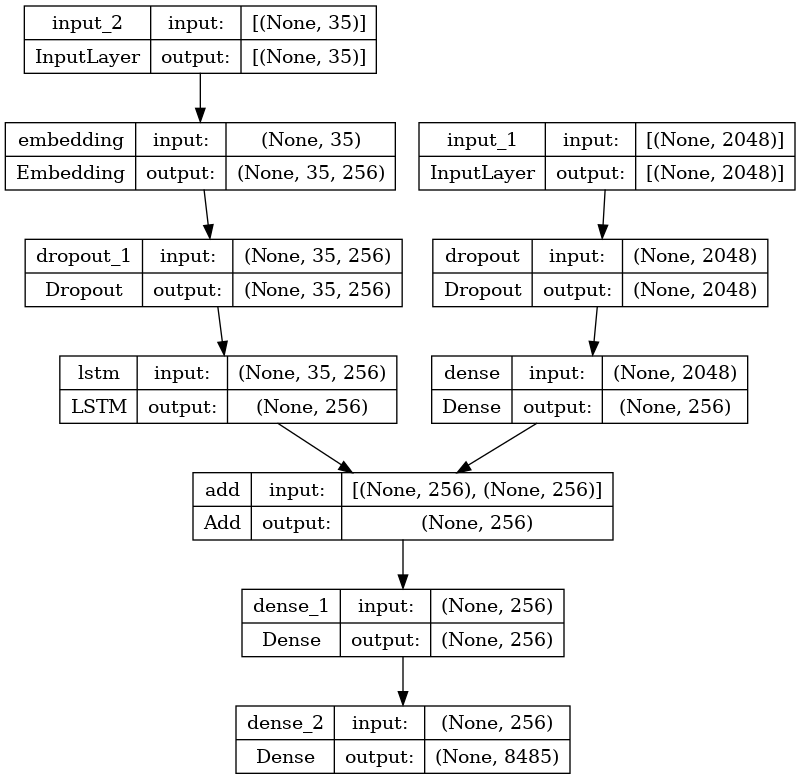

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True, show_layer_names = True)

In [25]:
os.mkdir("models")

In [27]:
model = load_model('/kaggle/input/saved-models/model_19.h5')

In [46]:
# train the model
#epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(60, 70):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

227/227 [==============================] - 42s 187ms/step - loss: 1.4989


## Generate Captions for the Image

In [25]:
model = load_model('/kaggle/input/saved-models/model_46.h5')

In [23]:
# function that returns the corresponding word to the given index in the vocabulary
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [24]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [52]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.527419
BLEU-2: 0.312790


In [32]:
## Visualize the Results

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are staring at each other endseq


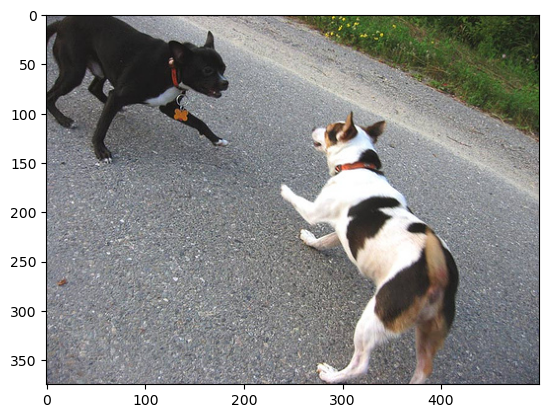

In [27]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl is playing with fingerpaints in front of painted wall endseq


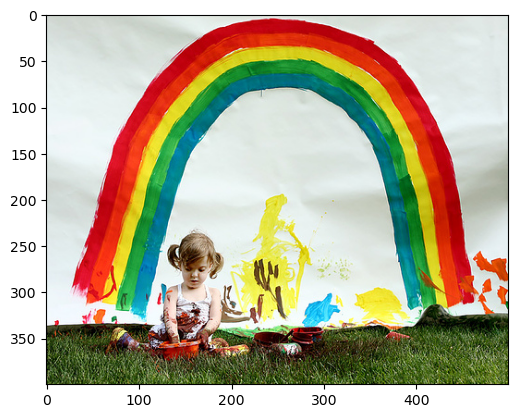

In [28]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq woman in black jacket and hat is displaying pictures on skis in front of snow covered landscape endseq


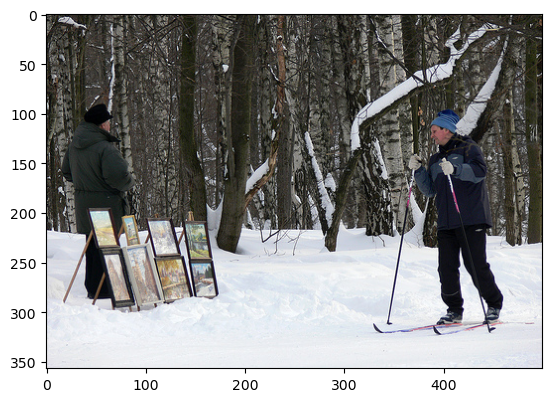

In [29]:
generate_caption("101669240_b2d3e7f17b.jpg")

In [30]:
# Load the pre-trained Xception model
base_model = Xception(weights='imagenet')
# Remove the top layer (fully connected layers)
xception_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

91884032/91884032 [==============================] - 4s 0us/step


**Generating captions for some test images using trained model**

In [34]:
# function that takes image path as an input and generates the output
def predict(image_path):
    img_show = Image.open(image_path)
    plt.imshow(img_show)
    plt.axis('off')
    # load image
    image = load_img(image_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = np.expand_dims(image, axis = 0)
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = xception_model.predict(image, verbose=0)
    # predict from the trained model
    caption = predict_caption(model, feature, tokenizer, max_length)
    plt.title(caption)
    plt.show()

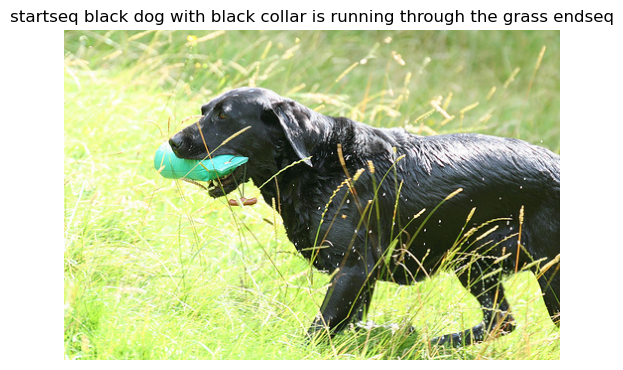

In [35]:
image_path = '/kaggle/input/flickr8k/Images/1026685415_0431cbf574.jpg'
predict(image_path)

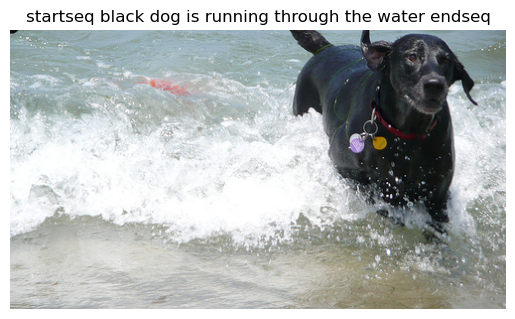

In [37]:
images_path = '/kaggle/input/flickr8k/Images/'
predict(images_path+'1022975728_75515238d8.jpg')

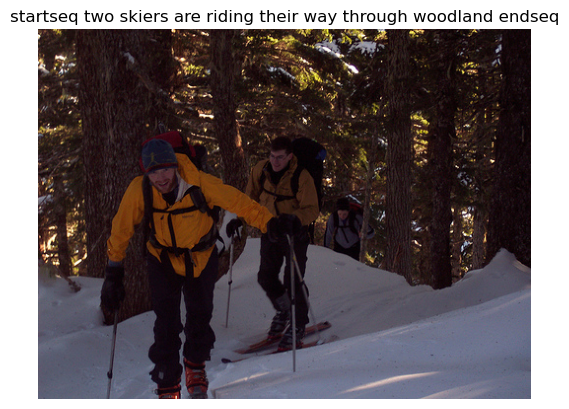

In [40]:
predict(images_path + '108898978_7713be88fc.jpg')

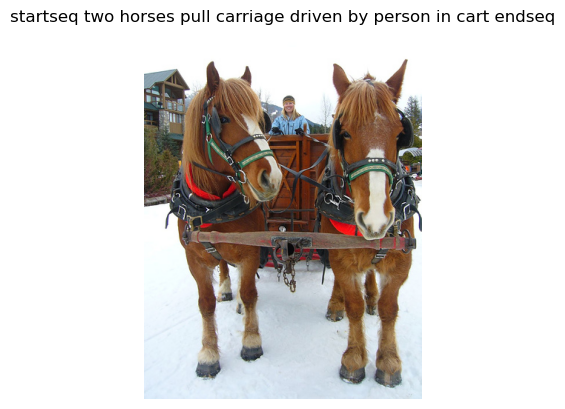

In [41]:
predict(images_path + '109202801_c6381eef15.jpg')

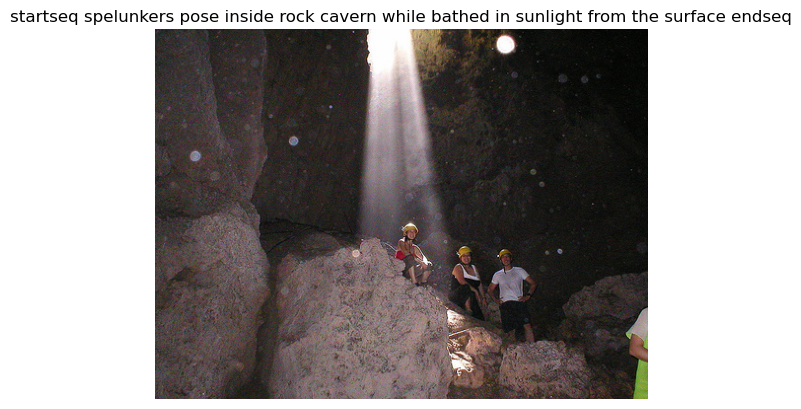

In [47]:
predict(images_path + '109260218_fca831f933.jpg')

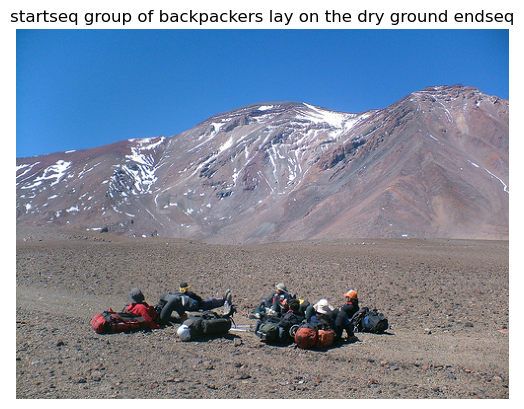

In [50]:
predict(images_path + '1093716555_801aacef79.jpg')

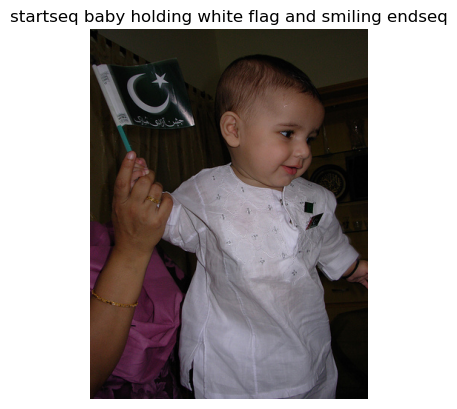

In [53]:
predict(images_path + '1122944218_8eb3607403.jpg')

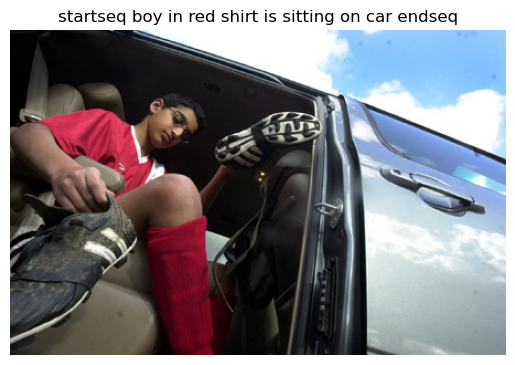

In [56]:
predict(images_path + '114051287_dd85625a04.jpg')

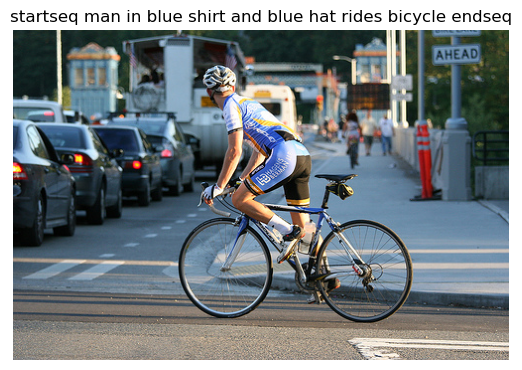

In [57]:
predict(images_path + '1143373711_2e90b7b799.jpg')

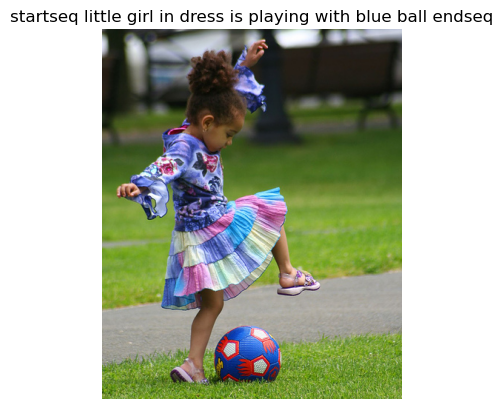

In [64]:
predict(images_path + '1248953128_24c9f8d924.jpg')

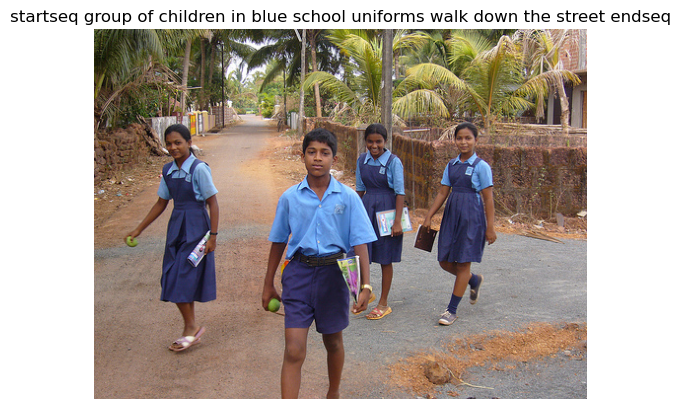

In [66]:
predict(images_path + '146098876_0d99d7fb98.jpg')

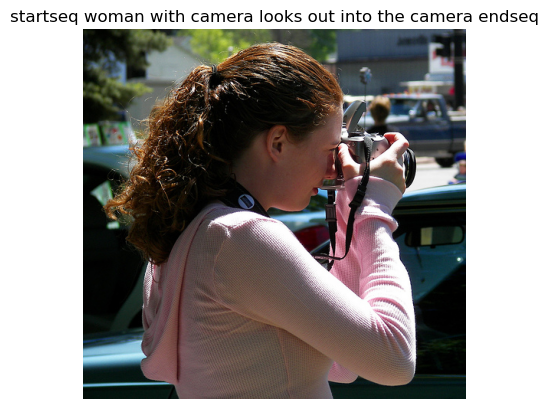

In [67]:
predict(images_path + '150582765_bad8dec237.jpg')

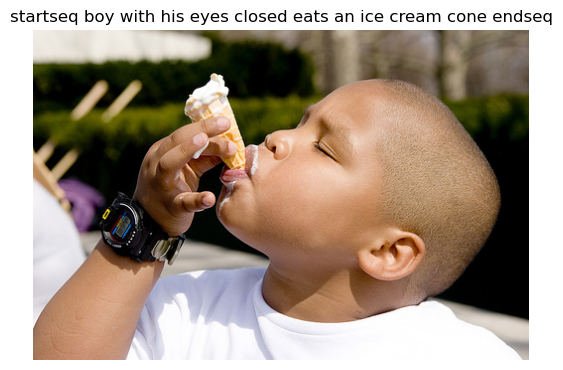

In [75]:
predict(images_path + '382151094_c7376cf22b.jpg')

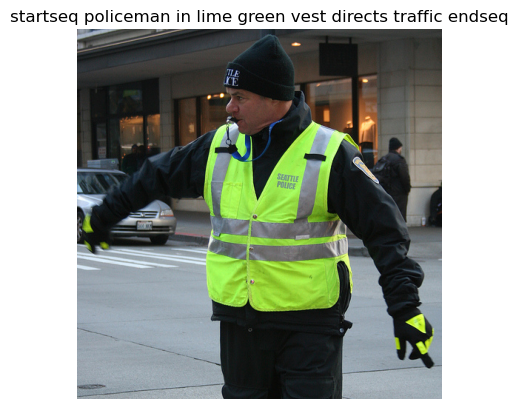

In [76]:
predict(images_path + '405615014_03be7ef618.jpg')

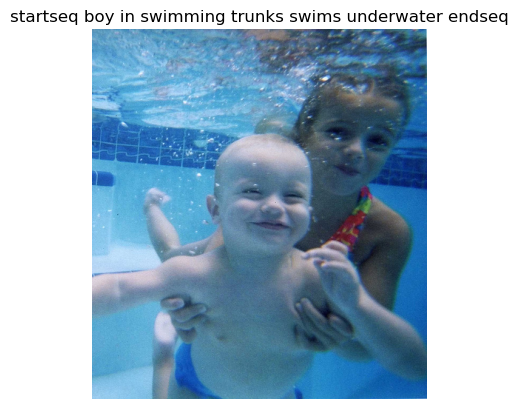

In [78]:
predict(images_path + '485738889_c2a00876a6.jpg')